In [35]:
import netCDF4 as nc
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as sts
import scipy
from matplotlib import style
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

*Para trabajar con los datos como pd en vez de como nc*

In [47]:
path='/Users/barbo/OneDrive/Escritorio/Analisis de datos/tema 3/datoscpd/'
files=['tmean_PI_mes_{}.nc'.format(i) for i in range(1,13)]

lon_barajas = -3.567
lat_barajas = 40.494

df_arr = np.empty((1,3))

for file in files:
    fil = nc.Dataset(path + file,'r')
    lon = fil.variables['lon'][:]
    lat = fil.variables['lat'][:]
    tiempo = fil.variables['time'] #sin los dos puntos para que sea variable ncdf
    tmedia = fil.variables['tmean'][:]

    lon_i = np.abs(lon-lon_barajas).argmin()
    lat_i = np.abs(lat-lat_barajas).argmin()

    temp = tmedia[:,lat_i,lon_i]
    tiempodates = nc.num2date(tiempo[:],tiempo.units) #ahora es un array de tiempos

    fechas = np.array([[fecha.month,fecha.year] for fecha in tiempodates])

    df_arr_i = np.c_[temp,fechas]
    df_arr = np.r_[df_arr,df_arr_i]



df1 = pd.DataFrame(df_arr[1:,:],columns=['temp','month','year']).astype({'month':int,'year':int}).dropna()

# hay un dato que hace que la representación falle, por eso seleccionamos todos 
# los valores de temperatura que esén por encima de los 0 grados

df = df1.loc[df1["temp"] >= 0 ]

print(lon[lon_i])
print(lat[lat_i])

-3.75
40.25


In [37]:
df

,temp,month,year
0,7.234882,1,1990
1,5.883603,1,1990
2,7.588984,1,1990
3,6.497338,1,1990
4,6.446887,1,1990
...,...,...,...
10952,8.648129,12,2019
10953,8.165260,12,2019
10954,7.994678,12,2019
10955,6.663296,12,2019


**AQUÍ UTILIZO LA FUNCIÓN DE DIEGO PARA OBTENER EL CLIMOGAMA**

In [51]:
cus = sns.color_palette("ch:start=0.2,rot=-0.5,dark=0.6, light=.9",12) # Paleta de color elegida
def climograma(df,start_year,end_year,save=False,violin = False, outliers = True, figname='barajas',fuente='',palette=cus):
    ''' 
    Función para realizar boxplots del ciclo estacional a partir de unos datos de temperatura a 2m.

    Entradas:
    - df: DataFrame con los datos de temperatura, extructurado por columnas de 'day','month','year','temp'
    - start_year: año de inicio del periodo que queremos representar 
    - end_year: año de fin del periodo que queremos representar 
    - save: si se quiere guardar la figura poner save=1
    - violin: si se quiere represnetar un diagrama de violines poner violin=1
    - outliers: si se quieren quitar los outliers del boxplot poner outliers=0
    - figname: nombre para el png si se pide guardar 'figname'+'.png'
    - fuente: str con el nombre de la fuente de los datos 
    - palette: paleta de colores que se quiere usar

    Salidas:
    - Tupla con la figura (fig) y el axis (ax) donde se representa el plot.
    
    '''
    df = df[(start_year <= df['year'])&(df['year'] <= end_year)]    # Selecciono los años
    means = df.groupby(['month'],dropna=True).mean('temp')          # Media de cada mes para representar encima    
    fig, ax = plt.subplots(figsize=(12,8))
    meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'] # Nombres de los meses para los xtick
    if violin == True: # Si queremos representarlo como violines
        sns.violinplot(data=df, x='month', y='temp', ax=ax, showfliers = False)
    else: 
        if outliers == True: # Boxplot con outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax,zorder=2,palette=palette) #,whis=2)
            
        else: # Boxplot sin outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax, showfliers = False,boxprops=dict(alpha=.7,zorder= 2),zorder=2)


    # Plot de la línea de medias
    ax.plot(np.arange(12), means['temp'],linewidth=5, color ='r',zorder=3, alpha=0.5, label='Media mesual')
    # Ajustes del ax
    ax.set_ylabel('Temperatura (ºC)', size=15 , fontweight = 'bold')
    ax.set_xlabel('Meses', size=15, fontweight = 'bold')
    ax.set_xticks(np.arange(12),meses,size=14) # Para cambiar las etiquetas a los nombres de meses
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(prop={'size':14})

    mid = (fig.subplotpars.right + fig.subplotpars.left)/2 # Para alinear el title y el suptitle
    plt.suptitle('Ciclo estacional',size=32, x=mid)
    plt.title(u'Fuente: %s; Periodo: %i-%i'%(fuente,start_year,end_year), size=18)
    plt.tight_layout()
    
    if save == True:  # Si queremos guardar la figura
        fig.savefig(figname+'.png',dpi=500,facecolor='w')
        
    return fig, ax



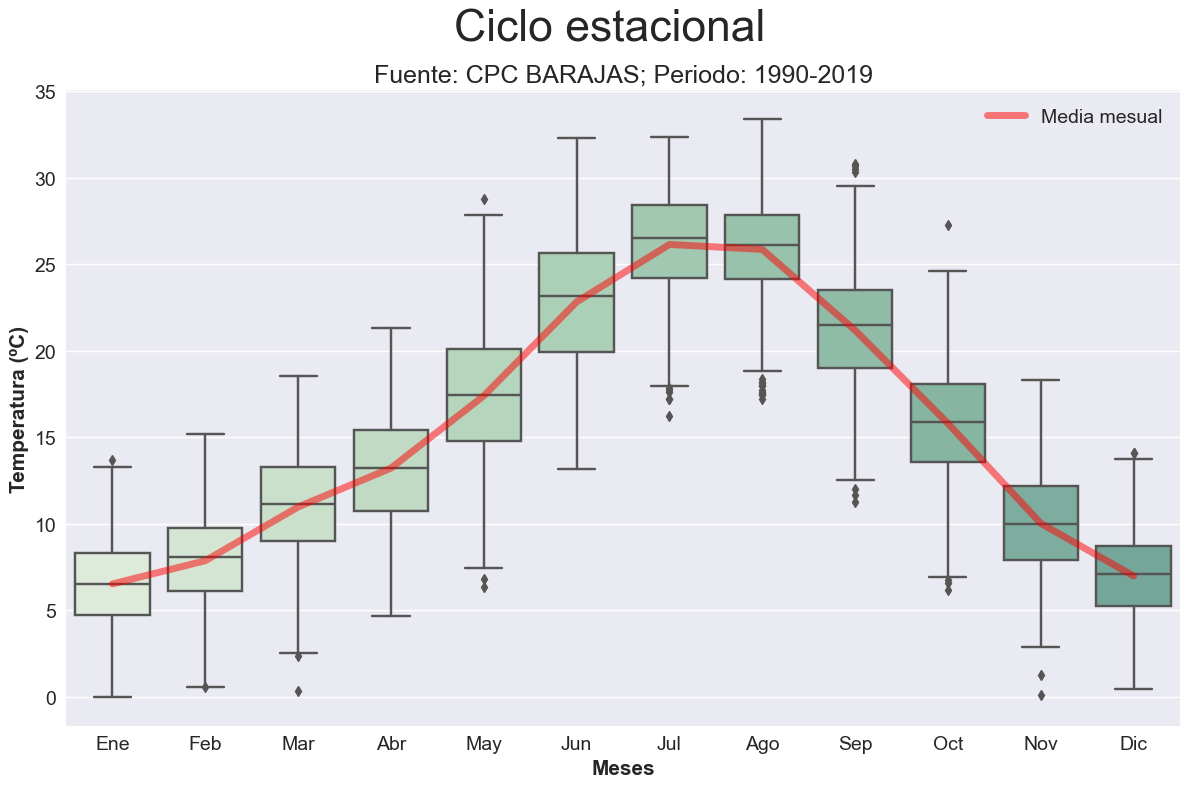

In [52]:
fig,ax = climograma(df, 1990, 2019, fuente = 'CPC BARAJAS' )

## Apartado 1.2.2

**ESTA ES LA PARTE DEL CÓDIGO DE VICTOR**

In [44]:
def histogram_plotter(data,variable,tit):
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/15)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,kde = False, stat='density', color='seagreen').set(title=tit)



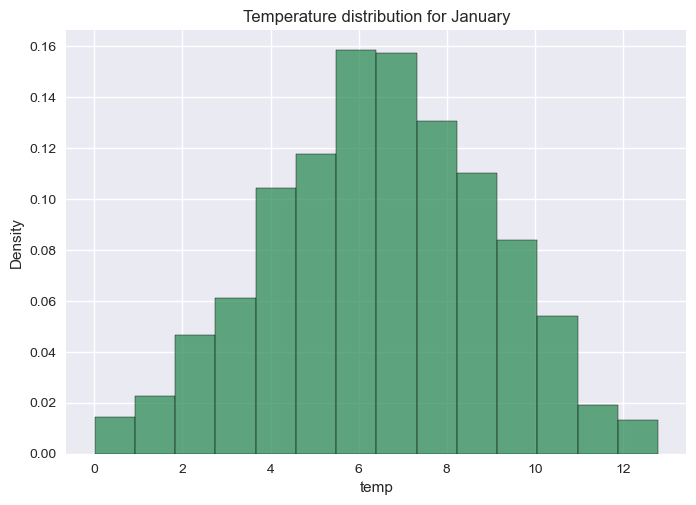

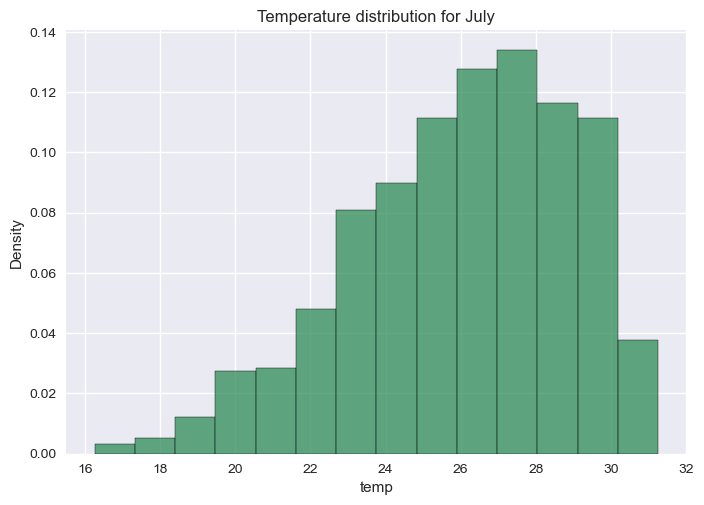

In [45]:

enero_1990_2019= df[df['month']==1]
julio_1990_2019= df[df['month']==7]

histogram_plotter(enero_1990_2019,'temp',tit='Temperature distribution for January')
histogram_plotter(julio_1990_2019,'temp',tit='Temperature distribution for July')

**DE NUEVO LLAMO A LA FUNCIÓN DE VICTOR**

In [48]:

def histogram_plotter_with_normal_estimation(data:pd.DataFrame,variable:str,variable_name:str,title:str, verbose:bool=True) -> None:
    """
    description:
    --------------------------------------
    
    arguments:
        - data: entry dataframe
        - variable: name of the variable of study
        - title: plot title
        - verbose: True if you want the stats asociated with the variable
    """
    mean= np.mean(data[variable])
    std= np.std(data[variable])
    n= np.shape(data[variable])[0]
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/20)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,stat='density', color='seagreen')
    normal_distribution= sts.norm.pdf(bins,mean,std)
    plt.plot(bins,normal_distribution,'red',label='Theoric')
    plt.legend(loc='best')
    plt.xlabel(variable_name)
    plt.title(title)
    plt.show()
    quantile_data= np.quantile(data[variable],(0.05,0.95))
    quantile_theoric= [sts.norm.ppf(0.05,mean,std),sts.norm.ppf(0.95,mean,std)]
    if verbose:
        print('Percentiles for the data are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_data[0],quantile_data[1]))
        print('Percentiles for the theoric distribution are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))
        print('Índice de Confianza del 95%')
        alfa=0.05
        #We must use the t-student distribution, beacuse with don't now the standard deviation of the data
        t_alpha_2= sts.t.ppf(1-alfa/2,n-1)
        ic= t_alpha_2*std/np.sqrt(n)
        print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))
        print('With scipy function:')
        ic_scipy=sts.t.interval(0.95,df=n-1,loc=mean,scale= std/np.sqrt(n))
        print(ic_scipy)


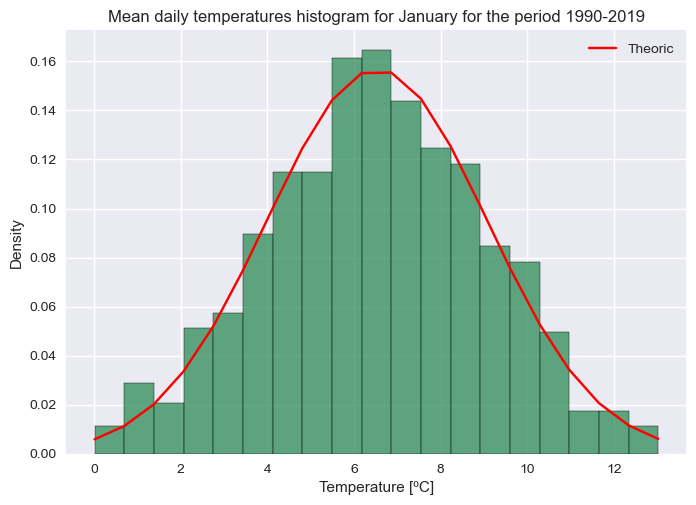

Percentiles for the data are: q(5%)=2.16 and q(95%)= 10.51
Percentiles for the theoric distribution are: q(5%)=2.34 and q(95%)= 10.72
Índice de Confianza del 95%
IC= [6.53+-0.16] (ºC)
With scipy function:
(6.3657783629721765, 6.695689497909043)


In [49]:
histogram_plotter_with_normal_estimation(enero_1990_2019,'temp','Temperature [ºC]','Mean daily temperatures histogram for January for the period 1990-2019')

#sale la representación pero hay un error debido a alpha


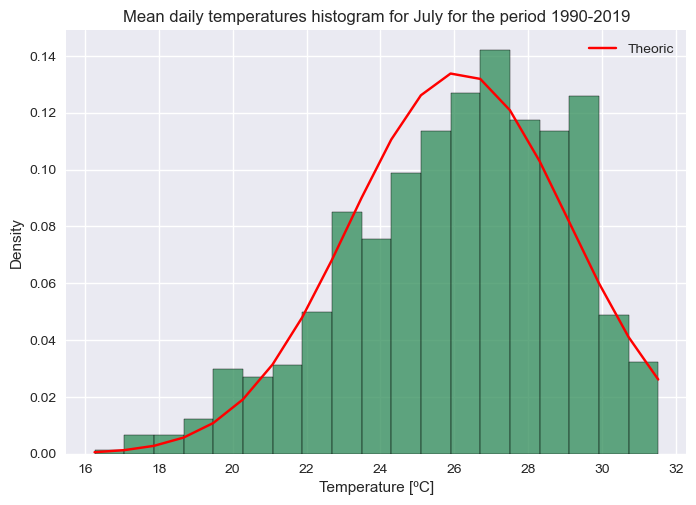

Percentiles for the data are: q(5%)=20.59 and q(95%)= 30.33
Percentiles for the theoric distribution are: q(5%)=21.26 and q(95%)= 31.03
Índice de Confianza del 95%
IC= [26.14+-0.19] (ºC)
With scipy function:
(25.951965449856605, 26.334596296401923)


In [50]:
histogram_plotter_with_normal_estimation(julio_1990_2019,'temp','Temperature [ºC]','Mean daily temperatures histogram for July for the period 1990-2019')

## Apartado 1.2.3

In [21]:
class StadisticalTests():
    # El método __init__ incluye toda la lógica necesaria para los índices de entrada y etiqueta.
    def __init__(self, x:pd.Series, y:pd.Series, alpha:float) -> None:
        
        self.x     = x
        self.y     = y
        self.alpha = alpha
   
    def f_test_stats(self) -> float:
        """
            Metodo que calcula el resultado p del test de Fisher para las varianzas, utilizando funciones de scipy.stats.

        Returns:
            float: el valor p. Si nuestro alpha que solemos determinarlo en 0.05, es mayor que p entonces nuestra hipotesis se acepta
                   en cambio, si el manor, debemos rechazar la hipotesis realizada.
        """
        
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        
        # Calculo de la p si esta es menor que 0.05 la aceptamos
        p = 1- sts.f.cdf (f, self.x.size-1, self.y.size-1) 
        return p
    
    def _f_fisher(self):
   
        n1 = self.x.size
        n2 = self.y.size
        
        f = sts.f.interval(self.alpha, n1, n2, loc=0, scale=1)
        return f
    
    def f_test_manual(self) -> bool:
        """
            Otro método para calcular el test de Fisher pero esta vez implementado de manera manual.
        
        Returns:
            bool: si el estadístico calculado, f , está dentro de nuestro intervalo de significancia
                devolvemos True sino False.
        """
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        f=1 # porque suponemos que son iguales
        
        # Intervalo de significancia con el alpha que hemos determinado
        isig = self._f_fisher()
        
        # Aceptamos o no la hipotesis?
        if f > isig[0] and f<isig[1]:
            print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return True
        else:
            print(f'Se ha rechazado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return False
    
    def _z(self):
        
        z = abs(np.mean(self.x) - np.mean(self.y)) / np.sqrt(np.var(self.x,ddof=1) / self.x.size + np.var(self.y,ddof=1) / self.y.size)
        return z

    def mean_test(self) -> bool:
        # Calculo valor con el que voy a comparar mi muestra
        z_alpha_2 = sts.norm.ppf(1-self.alpha/2)
    
        z = self._z()
        
        if z <= z_alpha_2:
            # Se acepta la hipotesis
            print(f'Se ha aceptado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return True
        else:
            # Se anula la hipotesis
            print(f'Se ha rechazado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return False
        
    def mean_test_stats(self):

        return sts.ttest_ind(self.x, self.y, nan_policy='omit', equal_var=False)

**Para hacer el contraste de hipótesis**

Necesito obtener los valores de temperatura del ISD history para los meses de Enero y Julio


In [22]:
url ="https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv"
#url = 'datos/isd/isd-history.csv'
c=pd.read_csv(url)
#Mostramos sólo los de España (código de país CTRY 'SP')
c.loc[c['CTRY']=='SP']


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
2848,080010,99999,LA CORUNA,SP,NaN,NaN,43.367,-8.417,67.0,19310101,20221101
2849,080020,99999,A CORUNA,SP,NaN,LECO,43.302,-8.377,98.5,19741001,20221101
2850,080030,99999,MONTEVENTOSO,SP,NaN,NaN,43.483,-8.317,240.0,19730101,19971231
2851,080050,99999,EL FERROL,SP,NaN,NaN,43.483,-8.233,9.0,19730101,20221006
2852,080070,99999,CERCEDA,SP,NaN,NaN,43.167,-8.533,595.0,20040517,20060207
...,...,...,...,...,...,...,...,...,...,...,...
12758,600350,99999,FUERTEVENTURA,SP,NaN,GCFV,28.453,-13.864,25.3,19500327,20221101
12759,600400,99999,LANZAROTE,SP,NaN,GCRR,28.945,-13.605,14.3,19500310,20221101
12817,603200,99999,CEUTA,SP,NaN,GECE,35.889,-5.347,88.0,19650101,20221101
12819,603380,99999,MELILLA,SP,NaN,GEML,35.280,-2.956,47.5,19641001,20221101


In [23]:
#Seleccionamos una estación. Por ejemplo BARAJAS
stationName = 'BARAJAS'

In [24]:
#Seleccionamos los años de inicio y final de lectura
yearInit = 1990
yearEnd = 2020

#Construimos el código que necesitamos para bajar los datos de la estación:
station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
    str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
print('Seleccionada la estacion ' + stationName + ' con código ' + station)

#Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

#Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
#(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]

#Lectura de los datos:
df=pd.DataFrame(columns=colNames)
for iyr in range(yearInit, yearEnd, 1):
    #Descomentar la siguiente línea si se prefiere hacer lectura directamente desde el servidor (lento)
    fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/082210-99999-'+str(iyr)+'.gz'
    #Esta línea es para leer los datos una vez descargados en la carpeta 'datos/isd/', cambiar si es necesario
    #fil='datos/isd/'+station+'-'+str(iyr)+'.gz'
    data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
    df = df.append(data)

#Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
dictType={ colNames[i] : dataType[i] for i in range(12)}
data = df.astype(dictType,copy=True)
#Los datos missing son -9999 en la base de datos: cambiamos por NaN:
data = data.replace(-9999,np.NaN)

#Calculamos medias diarias, mensuales y anuales
dataDailyMean = data.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
dataMonthlyMean = dataDailyMean.groupby(['year','month']).mean().reset_index()
dataYearlyMean = dataMonthlyMean.groupby(['year']).mean().reset_index()

Seleccionada la estacion BARAJAS con código 082210-99999


In [25]:
isd_enero_1990_2019 = data[data.month == 1]['temp']
isd_julio_1990_2019 = data[data.month == 7]['temp']

In [26]:
type(isd_enero_1990_2019), type(enero_1990_2019)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [27]:
alfa = 0.05
jan = StadisticalTests(x=enero_1990_2019['temp'], y=isd_enero_1990_2019, alpha  = alfa)
jul = StadisticalTests(x=julio_1990_2019['temp'], y=isd_julio_1990_2019, alpha = alfa)

In [28]:
# Resultados para enero
jan.f_test_manual()
jan.mean_test()

Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.


In [29]:
# Resultados para julio
jul.f_test_manual()
jul.mean_test()

Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
